# Composite Trotter-QDrift Simulator With Optimized Partitioning

> The number of gates required for trotter decomposition is exponential toward the length of the hamiltonian, while the number of gates for qDrift decomposition is largely dependent on $\lambda$ or the spectral norm. This composite method offers drastic improvments because we can partition the hamiltonian up favourably for these two methods, significantly reducing the number of gates required. This will allow for the simulation of quantum systems to be more practical for implementation on NISQ and ISQ hardware.

## Our Imports

In [2]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import QDrift, SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper



## Lets Get Our Molecular Hamiltonians

In [45]:
h2_driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735", 
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g')

h2_hamiltonian = JordanWignerMapper().map(h2_driver.run().hamiltonian.second_q_op())



## Genetic Algorithm Search For Partitioning

The number of gates required for trotter decomposition is exponential toward the length of the hamiltonian, while the number of gates for qdrift decomposition is largely dependent on $\lambda$ or the spectral norm. The composite method may offer improvemnts because we can partition the hamiltonian up favourably for these two methods, producing a less resource intensive quantum simulation method. This will allow it to be more practical for implementation on NISQ and ISQ hardware.

We use a genetic algorithm to search for a near-optimal partitioning of the hamilonian H into two hamiltonians for the Trotter and QDrift Channels. We partition H into two parts $H=A+B$ where A is the hamiltonian for the Trotter Channel $U_A(t)$ and QDrift Channel $U_B(t;N,M)$ We can define the total channel as $U_H(t) = U_A(t) \circ U_B(t; N,M)$

The cost or total number of gates for this composite channel is defined as
$$C_{cost} \leq (L_A+N_B)\frac{t^2}{\epsilon}\left(\sum_{i<j}a_ia_j||[A_i, A_j]||+\frac{1}{2}\sum_{ij}a_ib_j||[A_i,B_j]||+\frac{2\lambda^2}{N_B}\right)$$

We use this cost function as the fitness function in our genetic algorithm, and create partitions using the chromosomes


In [47]:
from genetic import run_genetic_algo

# First for H2
h2_least_cost, h2_h_trotter, h2_h_qdrift = run_genetic_algo(population_size=1000,num_generations=10,elite_prop=0.1,hamiltonian=h2_hamiltonian, N_b=200,e=1e-3,t=1,mutate_prob=0.1)

Generation 1 Lowest Number of Gates: 2884.0
Generation 2 Lowest Number of Gates: 2678.0
Generation 3 Lowest Number of Gates: 2070.0
Generation 4 Lowest Number of Gates: 2070.0
Generation 5 Lowest Number of Gates: 2070.0
Generation 6 Lowest Number of Gates: 2070.0
Generation 7 Lowest Number of Gates: 2070.0
Generation 8 Lowest Number of Gates: 2070.0
Generation 9 Lowest Number of Gates: 2070.0
Generation 10 Lowest Number of Gates: 2070.0
Lowest Number of Gates: 2070.0


## Number of Gates vs Error

In [53]:
from composite import Composite
from qiskit.synthesis import QDrift, SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from util import calc_reps_qdrift, calc_reps_trotter

errors = [10.0**(-1*x) for x in range(1,11)]

evo_h = PauliEvolutionGate(h2_hamiltonian, time=1)

trotter_gate_counts = []
qdrift_gate_counts = []
composite_gate_counts = []
for error in errors:
    trotter_circ = SuzukiTrotter(reps=1).synthesize(evo_h)
    qdrift_circ = QDrift(reps=1).synthesize(evo_h)
    
    composite_circ = Composite(h2_h_trotter,h2_h_qdrift, t=2, N_b=200, error=error)
    composite_circ.synthesize(need_reps=False)

    trotter_gate_counts.append(sum(dict(trotter_circ.count_ops()).values())*calc_reps_trotter(error, h2_hamiltonian, 2))
    qdrift_gate_counts.append(sum(dict(qdrift_circ.count_ops()).values())*calc_reps_qdrift(error,h2_hamiltonian,2))

    composite_gate_counts.append(composite_circ.count_gates(multiply_reps=True))
    print(f"Error={error} -> Trotter Gate Count: {trotter_gate_counts[-1]}, qDrift Gate Count: {qdrift_gate_counts[-1]}, Composite Gate Counts: {composite_gate_counts[-1]}")


Error=0.1 -> Trotter Gate Count: 86449, qDrift Gate Count: 8790, Composite Gate Counts: 1613
Error=0.01 -> Trotter Gate Count: 858081, qDrift Gate Count: 87810, Composite Gate Counts: 1652
Error=0.001 -> Trotter Gate Count: 8574401, qDrift Gate Count: 878070, Composite Gate Counts: 2107
Error=0.0001 -> Trotter Gate Count: 85737659, qDrift Gate Count: 8780700, Composite Gate Counts: 6566
Error=1e-05 -> Trotter Gate Count: 857370094, qDrift Gate Count: 87806985, Composite Gate Counts: 51221
Error=1e-06 -> Trotter Gate Count: 8573694502, qDrift Gate Count: 878069715, Composite Gate Counts: 497771
Error=1e-07 -> Trotter Gate Count: 85736938466, qDrift Gate Count: 8780697030, Composite Gate Counts: 4963193
Error=1e-08 -> Trotter Gate Count: 857369378251, qDrift Gate Count: 87806970165, Composite Gate Counts: 49617413
Error=1e-09 -> Trotter Gate Count: 8573693775956, qDrift Gate Count: 878069701650, Composite Gate Counts: 496159639
Error=1e-10 -> Trotter Gate Count: 85736937753006, qDrift Ga

## Lets Plot!

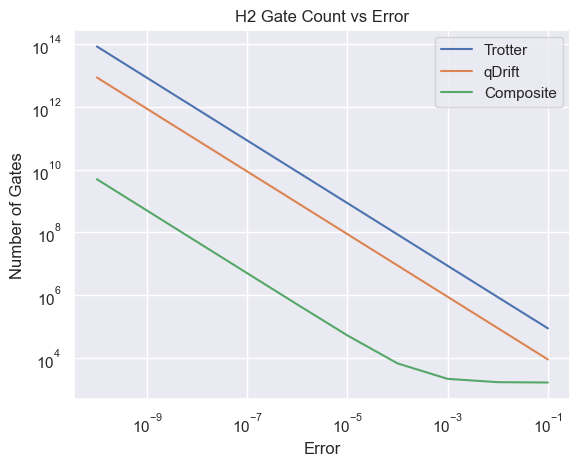

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.plot(errors,trotter_gate_counts,label='Trotter')
plt.plot(errors, qdrift_gate_counts,label='qDrift')
plt.plot(errors, composite_gate_counts,label='Composite')
plt.xlabel('Error')
plt.ylabel('Number of Gates')
plt.yscale('log')
plt.xscale('log')
plt.title('H2 Gate Count vs Error')
plt.legend()
plt.show()

Here we look at the scaling of the number of gates required against error for these 3 methods. As you can see there is a clear improvment with our composite trotter-qDrift method.

## Number of Gates vs Time
Now lets look at how the number of gates scales against time for these three methods

In [61]:
from composite import Composite
from qiskit.synthesis import QDrift, SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from util import calc_reps_qdrift, calc_reps_trotter

error = 1e-3
times = [10*x for x in range(1,11)]

evo_h = PauliEvolutionGate(h2_hamiltonian, time=1)

trotter_gate_counts = []
qdrift_gate_counts = []
composite_gate_counts = []
for time in times:
    trotter_circ = SuzukiTrotter(reps=1).synthesize(evo_h)
    qdrift_circ = QDrift(reps=1).synthesize(evo_h)
    
    composite_circ = Composite(h2_h_trotter,h2_h_qdrift, t=time, N_b=200, error=error)
    composite_circ.synthesize(need_reps=False)

    trotter_gate_counts.append(sum(dict(trotter_circ.count_ops()).values())*calc_reps_trotter(error, h2_hamiltonian, time))
    qdrift_gate_counts.append(sum(dict(qdrift_circ.count_ops()).values())*calc_reps_qdrift(error,h2_hamiltonian,time))

    composite_gate_counts.append(composite_circ.count_gates(multiply_reps=True))
    print(f"Time={time} -> Trotter Gate Count: {trotter_gate_counts[-1]}, qDrift Gate Count: {qdrift_gate_counts[-1]}, Composite Gate Counts: {composite_gate_counts[-1]}")


Time=10 -> Trotter Gate Count: 214345873, qDrift Gate Count: 21951750, Composite Gate Counts: 50615
Time=20 -> Trotter Gate Count: 857376445, qDrift Gate Count: 87806985, Composite Gate Counts: 202421
Time=30 -> Trotter Gate Count: 1929091687, qDrift Gate Count: 197565690, Composite Gate Counts: 455244
Time=40 -> Trotter Gate Count: 3429491628, qDrift Gate Count: 351227895, Composite Gate Counts: 809271
Time=50 -> Trotter Gate Count: 5358576239, qDrift Gate Count: 548793570, Composite Gate Counts: 1264302
Time=60 -> Trotter Gate Count: 7716345578, qDrift Gate Count: 790262745, Composite Gate Counts: 1820550
Time=70 -> Trotter Gate Count: 10502799558, qDrift Gate Count: 1075635390, Composite Gate Counts: 2478002
Time=80 -> Trotter Gate Count: 13717938266, qDrift Gate Count: 1404911535, Composite Gate Counts: 3236658
Time=90 -> Trotter Gate Count: 17361761644, qDrift Gate Count: 1778091150, Composite Gate Counts: 4096331
Time=100 -> Trotter Gate Count: 21434269721, qDrift Gate Count: 219

## Lets Plot

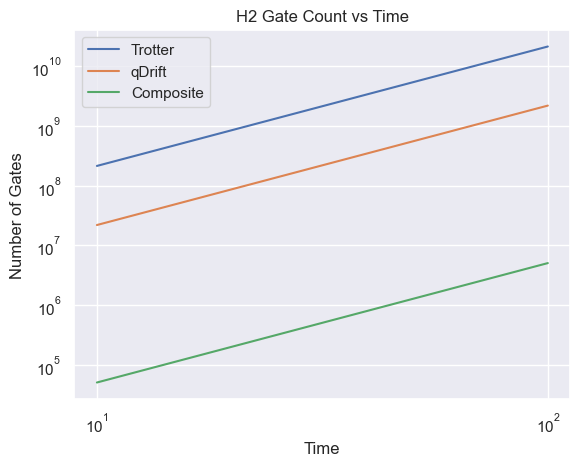

In [66]:
plt.plot(times,trotter_gate_counts,label='Trotter')
plt.plot(times, qdrift_gate_counts,label='qDrift')
plt.plot(times, composite_gate_counts,label='Composite')
plt.xlabel('Time')
plt.ylabel('Number of Gates')
plt.yscale('log')
plt.xscale('log')
plt.title('H2 Gate Count vs Time')
plt.legend()
plt.show()

## IQPE

Now lets try to demonstrate the applications of our method. One big application of quantum simulations is in Quantum Phase Estimation. Quantum Phase Estimation is one of the most importnant tools and if harnessed could have huge benefits to the world; however, it requires a lot of qubits making it difficult to implement on hardware. IQPE (Iterative Quantum Phase Estimation) is another algorithm that significntly reduces the number of qubits required.

Lets see if our method is more effective than typical trotter or qDrift for quantum phase estimation.